# Bob.FM Hardware FIR Filter

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
from scipy.fftpack import fft, ifft, fftfreq

In [90]:
def signal_gen(frequency=0.5, amplitude=1, phase_degrees=0, duration=1, 
               sampling_freq=1):
    """A signal generator"""
    phase = phase_degrees * np.pi/180
    try:
        time  = np.arange(0,duration, 1/sampling_freq) # X axis: Time & Samples
    except MemoryError as err:
        print("Please set a shorter duration or smaller sampling frequency")
        time  = np.arange(0,3/frequency, 1/sampling_freq) # X axis: Time & Samples
    
    return time, amplitude*np.sin(2*np.pi*frequency*time+phase)

def dB(voltage):
    """Converts voltage to dB"""
    return 20 * np.log10(voltage)

def rthomp_fft(signal, sampling_freq):
    """Performs an FFT on the signal provided"""
    nfft       = int(5*2**(np.ceil(np.log2(len(signal))))) # Deligating freq bings
    signal_fft = fft(signal, nfft)/len(signal)             # Perform FFT
    fft_freq   = fftfreq(nfft, 1/sampling_freq)            # Extract frequencies
    
    # Taking the magnitude and sectioning off the imag. freq
    signal_fft = dB(2*abs(signal_fft[0:nfft//2]))
    fft_freq   = fft_freq[0:nfft//2]
    
    return fft_freq, signal_fft

### Signal generation

(75000000.0, 150000000.0)

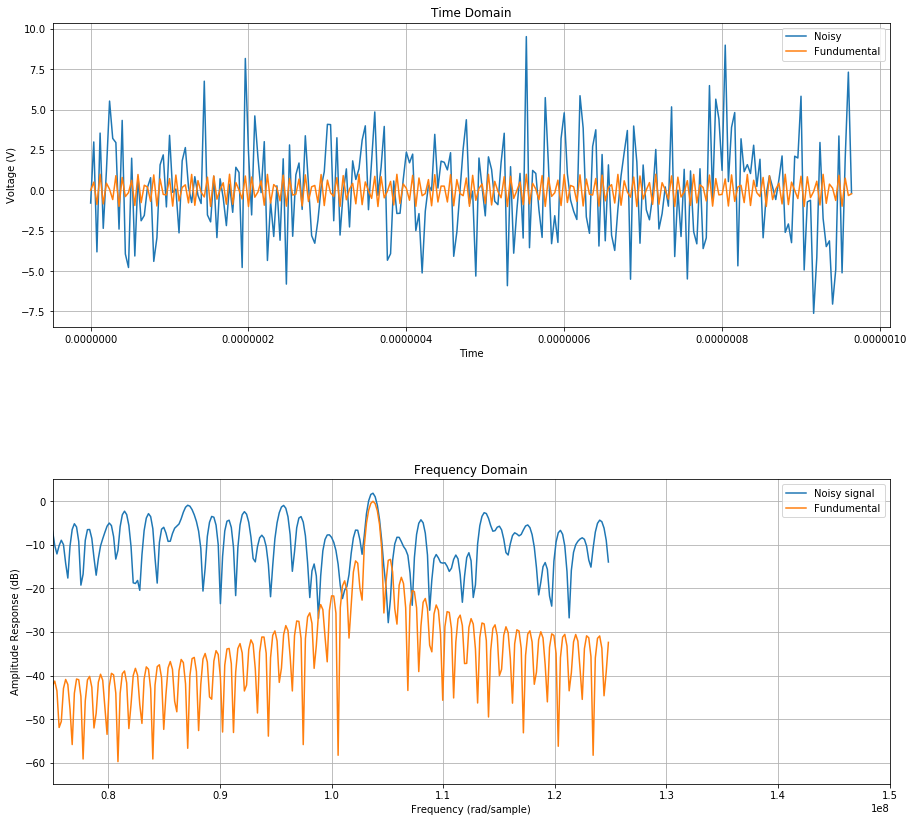

In [101]:
# Fundumental signal
freq = 103.7e6 # bob.fm station
amp = 1
Fs = 250e6
dur = 100.1/freq    # 100.1 cycles
t, s_fundumental = signal_gen(freq,sampling_freq=Fs, duration=dur, amplitude=amp)

# Gaussian noise signal with zero mean and unit variance
variance = 10
stdev = np.sqrt(variance)
noise = np.random.normal(0,stdev,np.size(t))

# Makes the signal noisy
s = s_fundumental + noise

# FFTs
nfft, S             = rthomp_fft(s, Fs)
nfft, S_fundumental = rthomp_fft(s_fundumental, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
plt.plot(t, s_fundumental, label='Fundumental')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_fundumental, label="Fundumental")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()
plt.xlim(75e6,150e6)
# plt.ylim(-50,10)

### Filter Design
This part encapsulates the design decisions of the BOB.FM FIR filter.
            
    Center Frequency (fr): 103.7MHz
    FM Passband: 200kHz
    Sampling frequency (Fs): 250MHz
    
References: [T-Filt](http://t-filter.engineerjs.com/), [mytexttools](https://mytexttools.com/find-and-replace-text.html)

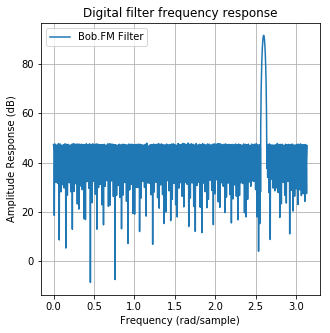

In [113]:
# Filter parameters
fr     = 103.7e6 # Bob.FM station
nfft   = int(5*2**(np.ceil(np.log2(len(s)))))

b = [91, 51, -49, 49, -45, 36, -21, 1, 18, -32, 36, -29, 12, 11, -33, 47, -48, 35, -11, -18, 45, -60, 58, -39, 7, 30, -60, 75, -68, 41, 0, -44, 77, -91, 78, -41, -10, 61, -97, 107, -86, 38, 23, -81, 119, -123, 92, -32, -40, 104, -141, 138, -95, 22, 61, -130, 164, -152, 94, -7, -86, 158, -187, 162, -90, -12, 114, -187, 208, -170, 80, 36, -145, 217, -228, 173, -66, -63, 179, -246, 244, -171, 47, 95, -214, 274, -256, 164, -22, -130, 249, -299, 264, -151, -7, 168, -284, 320, -265, 133, 41, -207, 317, -337, 261, -108, -79, 247, -347, 349, -250, 78, 119, -286, 373, -354, 233, -44, -161, 322, -394, 353, -210, 5, 203, -356, 409, -345, 181, 36, -245, 386, -417, 329, -147, -80, 285, -410, 418, -307, 108, 124, -321, 428, -413, 279, -66, -167, 353, -439, 399, -246, 22, 208, -379, 442, -379, 208, 22, -246, 399, -439, 353, -167, -66, 279, -413, 428, -321, 124, 108, -307, 418, -410, 285, -80, -147, 329, -417, 386, -245, 36, 181, -345, 409, -356, 203, 5, -210, 353, -394, 322, -161, -44, 233, -354, 373, -286, 119, 78, -250, 349, -347, 247, -79, -108, 261, -337, 317, -207, 41, 133, -265, 320, -284, 168, -7, -151, 264, -299, 249, -130, -22, 164, -256, 274, -214, 95, 47, -171, 244, -246, 179, -63, -66, 173, -228, 217, -145, 36, 80, -170, 208, -187, 114, -12, -90, 162, -187, 158, -86, -7, 94, -152, 164, -130, 61, 22, -95, 138, -141, 104, -40, -32, 92, -123, 119, -81, 23, 38, -86, 107, -97, 61, -10, -41, 78, -91, 77, -44, 0, 41, -68, 75, -60, 30, 7, -39, 58, -60, 45, -18, -11, 35, -48, 47, -33, 11, 12, -29, 36, -32, 18, 1, -21, 36, -45, 49, -49, 51, 91]
w, response = signal.freqz(b, worN=nfft)

# Frequency Response
plt.figure('position', [5,5])
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(abs(response)), label='Bob.FM Filter')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()

### Applying the filter

Now that we have the filter's zeroes, we'll apply it on a random signal to see if it works.

(-50, 86.01042496213623)

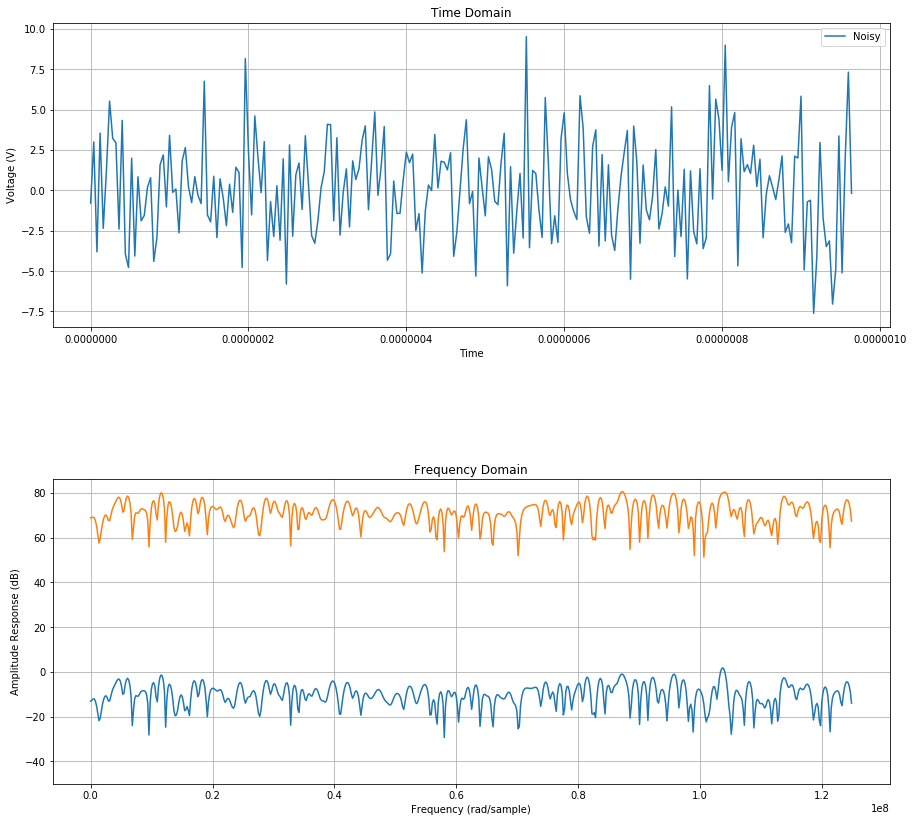

In [104]:
# Filter applied
s_filt = signal.lfilter(b,1,s)

# FFTs
nfft, S = rthomp_fft(s,Fs)
nfft, S_filt = rthomp_fft(s_filt, Fs)

# Graph
plt.figure('position', [15,14])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title("Time Domain")
plt.plot(t, s, label='Noisy')
# plt.plot(t, s_filt, label='Not noisy')
plt.ylabel('Voltage (V)')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Frequency Domain')
plt.plot(nfft, S, label="Noisy signal")
plt.plot(nfft, S_filt, label="Filtered Noisy Signal")
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.ylim(-50)